In [11]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [2]:
with open('./data/data_mp.csv', encoding='utf-8') as f_in:
    y = []
    texts = []
    for line in f_in:
        movie_id, sentiment, text = line.strip('\n').split('\t', 3)
        if sentiment=='negative' or sentiment=='positive':
            y.append(1 if sentiment=='positive' else 0)
            texts.append(text)

In [3]:
%%time
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(texts)
print(X.shape)

(3240, 87073)
Wall time: 2.41 s


In [4]:
%%time
y_pred_cv = cross_val_predict(LogisticRegression(), X, y, cv=4, n_jobs=-1, verbose=True, method='predict_proba')
print('Cross-validated AUC: %.4f' % roc_auc_score(y, y_pred_cv[:,1]))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Cross-validated AUC: 0.8813
Wall time: 2.67 s


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    2.6s finished


In [20]:
%%time
L = LogisticRegression(solver='lbfgs', class_weight='balanced')
L.fit(X, y)

features = tfidf.get_feature_names()
features_with_weights = pd.DataFrame(zip(features, L.coef_[0]), columns=['feature', 'weight']).sort_values('weight')

Wall time: 791 ms


In [21]:
features_with_weights

,feature,weight
47118,оттенков,-3.232329
3479,бдсм,-3.138508
16178,джонсон,-2.714719
224,50,-2.573210
68360,серого,-2.522522
27710,книге,-2.498490
9397,вообще,-2.397881
27711,книги,-2.375451
14203,грей,-2.373242
37683,не,-2.295288


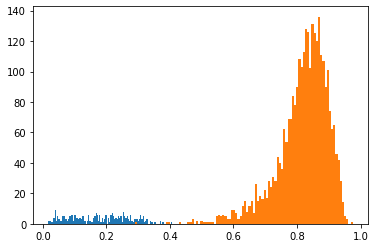

0.4141414141414142 0.9990740740740741


In [16]:
plt.hist(L.predict_proba(X[np.array(y) == 0])[:, 1], bins=100)
plt.hist(L.predict_proba(X[np.array(y) == 1])[:, 1], bins=100)
plt.show()

best_threshold, best_accuracy = 0.0, 0.0
for _ in np.linspace(0, 1, 100):
    correct_0 = np.sum(L.predict_proba(X[np.array(y) == 0])[:, 1] < _)
    correct_1 = np.sum(L.predict_proba(X[np.array(y) == 1])[:, 1] > _)
    accuracy_0 = (correct_0) / (np.sum(np.array(y) == 0))
    accuracy_1 = (correct_1) / (np.sum(np.array(y) == 1))
    accuracy = (correct_0 + correct_1) / (np.sum(np.array(y) == 0) + np.sum(np.array(y) == 1))
    if best_accuracy < accuracy:
        best_threshold, best_accuracy = _, accuracy
#     print("{0:.3f}\t{1:.3f}\t{2:.3f}\t{3:.3f}\t".format(_, accuracy_0, accuracy_1, accuracy))
print(best_threshold, best_accuracy)

In [17]:
with open('data/logreg.pkl', 'wb') as f_out:
    pickle.dump(L, f_out)
with open('data/tf-idf.pkl', 'wb') as f_out:
    pickle.dump(tfidf, f_out)
with open('data/params.pkl', 'wb') as f_out:
    pickle.dump({'threshold': best_threshold}, f_out)